In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from keras.models import Sequential
from keras.layers import Dense, Activation, Embedding, Flatten, LeakyReLU, Merge, BatchNormalization

from sklearn.preprocessing import StandardScaler

%matplotlib inline

Using TensorFlow backend.


Description of the data:

- instant: record index
- dteday : date
- season : season (1:springer, 2:summer, 3:fall, 4:winter)
- yr : year (0: 2011, 1:2012)
- mnth : month ( 1 to 12)
- hr : hour (0 to 23)
- holiday : weather day is holiday or not (extracted from [Web Link])
- weekday : day of the week
- workingday : if day is neither weekend nor holiday is 1, otherwise is 0.
+ weathersit : 
  - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
  - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
  - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
  - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
- temp : Normalized temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-8, t_max=+39 (only in hourly scale)
- atemp: Normalized feeling temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-16, t_max=+50 (only in hourly scale)
- hum: Normalized humidity. The values are divided to 100 (max)
- windspeed: Normalized wind speed. The values are divided to 67 (max)
- casual: count of casual users
- registered: count of registered users
- cnt: count of total rental bikes including both casual and registered

In [3]:
rides = pd.read_csv('data/hour.csv')
rides['time'] = pd.to_datetime(rides['dteday'])+pd.Series([pd.DateOffset(hours = a ) for a in rides.hr.tolist()])
rides.drop(['instant','yr','dteday','casual','registered', 'atemp'],1,inplace=True)
rides['t'] = rides.time.values.astype(float)
rides.head()

/root/miniconda3/lib/python3.6/site-packages/pandas/core/ops.py:539: PerformanceWarning: Adding/subtracting array of DateOffsets to Series not vectorized
  "Series not vectorized", PerformanceWarning)


,season,mnth,hr,holiday,weekday,workingday,weathersit,temp,hum,windspeed,cnt,time,t
0,1,1,0,0,6,0,1,0.24,0.81,0.0,16,2011-01-01 00:00:00,1.293840e+18
1,1,1,1,0,6,0,1,0.22,0.80,0.0,40,2011-01-01 01:00:00,1.293844e+18
2,1,1,2,0,6,0,1,0.22,0.80,0.0,32,2011-01-01 02:00:00,1.293847e+18
3,1,1,3,0,6,0,1,0.24,0.75,0.0,13,2011-01-01 03:00:00,1.293851e+18
4,1,1,4,0,6,0,1,0.24,0.75,0.0,1,2011-01-01 04:00:00,1.293854e+18


In [4]:
rides.weekday.nunique()

7

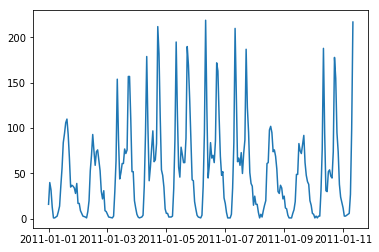

In [5]:
plt.plot(rides.time[:240],rides.cnt[:240])
plt.show()

In [6]:
quant_features = ['temp', 'hum', 'windspeed','t']
x_scaler = StandardScaler()
rides[quant_features] = x_scaler.fit_transform(rides[quant_features].values)

y_scaler = StandardScaler()
rides['cnt'] = y_scaler.fit_transform(rides['cnt'].values[:,None])

rides.head()

/root/miniconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


,season,mnth,hr,holiday,weekday,workingday,weathersit,temp,hum,windspeed,cnt,time,t
0,1,1,0,0,6,0,1,-1.334648,0.947372,-1.553889,-0.956339,2011-01-01 00:00:00,-1.745435
1,1,1,1,0,6,0,1,-1.438516,0.895539,-1.553889,-0.824022,2011-01-01 01:00:00,-1.745236
2,1,1,2,0,6,0,1,-1.438516,0.895539,-1.553889,-0.868128,2011-01-01 02:00:00,-1.745038
3,1,1,3,0,6,0,1,-1.334648,0.636370,-1.553889,-0.972879,2011-01-01 03:00:00,-1.744840
4,1,1,4,0,6,0,1,-1.334648,0.636370,-1.553889,-1.039037,2011-01-01 04:00:00,-1.744641


In [7]:
rides['cnt'].values.shape

(17379,)

In [8]:
rides['cnt'].values[:,None].shape

(17379, 1)

In [9]:
rides['cnt'].values[None,:].shape

(1, 17379)

In [10]:
cat_features = ['season', 'hr', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit']

# Preprocess data so that it starts from 0
for feature in cat_features:
    if rides[feature].min() > 0:
        rides[feature] -= 1

# Embed the models
cat_models = []
for feature in cat_features:
    model_cat = Sequential()
    model_cat.add(Embedding(rides[feature].nunique(),10,input_length=1))
    model_cat.add(Flatten())
    cat_models.append(model_cat)
    
cat_model = Sequential()
cat_model.add(Merge(cat_models))

/root/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.


In [11]:
cat_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
merge_1 (Merge)              (None, 10)                0         
Total params: 550.0
Trainable params: 550.0
Non-trainable params: 0.0
_________________________________________________________________


In [12]:
feature

'weathersit'

In [13]:
rides[feature].nunique()

4

In [14]:
model_cat.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 1, 10)             40        
_________________________________________________________________
flatten_7 (Flatten)          (None, 10)                0         
Total params: 40.0
Trainable params: 40.0
Non-trainable params: 0.0
_________________________________________________________________


In [15]:
rides[quant_features].head()

,temp,hum,windspeed,t
0,-1.334648,0.947372,-1.553889,-1.745435
1,-1.438516,0.895539,-1.553889,-1.745236
2,-1.438516,0.895539,-1.553889,-1.745038
3,-1.334648,0.636370,-1.553889,-1.744840
4,-1.334648,0.636370,-1.553889,-1.744641


In [16]:
rides.head()

,season,mnth,hr,holiday,weekday,workingday,weathersit,temp,hum,windspeed,cnt,time,t
0,0,0,0,0,6,0,0,-1.334648,0.947372,-1.553889,-0.956339,2011-01-01 00:00:00,-1.745435
1,0,0,1,0,6,0,0,-1.438516,0.895539,-1.553889,-0.824022,2011-01-01 01:00:00,-1.745236
2,0,0,2,0,6,0,0,-1.438516,0.895539,-1.553889,-0.868128,2011-01-01 02:00:00,-1.745038
3,0,0,3,0,6,0,0,-1.334648,0.636370,-1.553889,-0.972879,2011-01-01 03:00:00,-1.744840
4,0,0,4,0,6,0,0,-1.334648,0.636370,-1.553889,-1.039037,2011-01-01 04:00:00,-1.744641


In [17]:
quant_model = Sequential()
quant_model.add(Dense(len(quant_features),input_dim=len(quant_features)))
quant_model.add(LeakyReLU())

In [18]:
# model = Sequential()
# model.add(Merge([cat_model, quant_model, quant_model], mode='concat'))
model = quant_model
model.add(Dense(15))
model.add(LeakyReLU())
model.add(Dense(1))
model.compile(optimizer='adadelta', loss='mse')

In [19]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 4)                 20        
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 4)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 15)                75        
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 15)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 16        
Total params: 111.0
Trainable params: 111.0
Non-trainable params: 0.0
_________________________________________________________________


In [20]:
# Save the last 21 days 
test_data = rides[-21*24:]
train_data = rides[:-21*24]

In [21]:
train_x = [train_data[col].values for col in cat_features+[quant_features]]
test_x = [test_data[col].values for col in cat_features+[quant_features]]

# Train the model
model.fit(train_x, train_data['cnt'], batch_size=256)

ValueError: Error when checking model input: the list of Numpy arrays that you are passing to your model is not the size the model expected. Expected to see 1 arrays but instead got the following list of 8 arrays: [array([0, 0, 0, ..., 3, 3, 3]), array([ 0,  1,  2, ..., 19, 20, 21]), array([ 0,  0,  0, ..., 11, 11, 11]), array([0, 0, 0, ..., 0, 0, 0]), array([6, 6, 6, ..., 1, 1, 1]), array([0, 0, 0, ..., 1, 1, ...

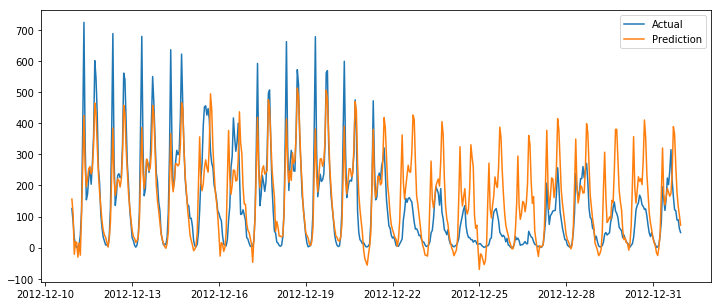

In [12]:
pred_y = model.predict(test_x, batch_size=256)
plt.figure(figsize=(12,5))
plt.plot(test_data.time, y_scaler.inverse_transform(test_data.cnt), label='Actual')
plt.plot(test_data.time, y_scaler.inverse_transform(pred_y), label='Prediction')
plt.legend()
plt.show()

In [13]:
model.evaluate(test_x, test_data['cnt'], batch_size=256)

256/504 [==============>...............] - ETA: 0s

0.31514962041188799

In [53]:
from keras.losses import mean_squared_error
import keras.backend as K

def r_squared(y_true, y_pred):
    """
    Coefficient of Determination. The closer this metric is to 1 the better the prediction.
    https://en.wikipedia.org/wiki/Coefficient_of_determination
    """
    mean_squared_pred = mean_squared_error(y_true, y_pred)
    mean_squared_total = mean_squared_error(y_true, K.mean(y_true, axis=-1, keepdims=True))
    return 1 - mean_squared_pred / mean_squared_total

In [54]:
quant_model = Sequential()
quant_model.add(Dense(len(quant_features),input_dim=len(quant_features)))
model.add(BatchNormalization())
quant_model.add(LeakyReLU())

model = Sequential()
model.add(Merge([cat_model, quant_model], mode='concat'))
model.add(Dense(15))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(Dense(1))
model.compile(optimizer='adadelta', loss='mse', metrics=[r_squared])

model.fit(train_x, train_data['cnt'].values, batch_size=256)

/root/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  import sys


Epoch 1/10
16875/16875 [==============================] - 1s - loss: 1.2529 - r_squared: -inf     
Epoch 2/10
16875/16875 [==============================] - 0s - loss: 0.5546 - r_squared: -inf     
Epoch 3/10
16875/16875 [==============================] - 0s - loss: 0.3513 - r_squared: -inf     
Epoch 4/10
16875/16875 [==============================] - 0s - loss: 0.3009 - r_squared: -inf     
Epoch 5/10
16875/16875 [==============================] - 0s - loss: 0.2741 - r_squared: -inf     
Epoch 6/10
16875/16875 [==============================] - 0s - loss: 0.2498 - r_squared: -inf     
Epoch 7/10
16875/16875 [==============================] - 0s - loss: 0.2327 - r_squared: -inf     
Epoch 8/10
16875/16875 [==============================] - 0s - loss: 0.2136 - r_squared: -inf     
Epoch 9/10
16875/16875 [==============================] - 0s - loss: 0.1977 - r_squared: -inf     
Epoch 10/10
16875/16875 [==============================] - 0s - loss: 0.1841 - r_squared: -inf     


In [55]:
y_pred = model.predict(train_x).ravel()
y_true = train_data['cnt'].values

In [56]:
msp = np.mean(np.square(y_true - y_pred))
mst = np.mean(np.square(y_true - np.mean(y_true)))
1 - msp/mst

0.83269215782764783

In [60]:
K.eval(r_squared(K.variable(y_true[:,None]), K.variable(y_pred)))

array([-inf, -inf, -inf, ..., -inf, -inf, -inf], dtype=float32)

In [44]:
(y_true - np.mean(y_true))

array([-0.96429081, -0.83197366, -0.87607938, ...,  1.30164042,
        0.60146215,  0.29823535])

In [22]:
model.evaluate(test_x, test_data['cnt'], batch_size=256)

256/504 [==============>...............] - ETA: 0s

0.22712602596434336